In [146]:

import pandas as pd
from glob import glob
from pathlib import Path


In [159]:
# Load clinical data
demographics_df = pd.read_csv('participants.tsv', sep='\t',na_filter=False)



In [191]:
#for plotting
genotype_order=demographics_df.sort_values(by='group_label').drop_duplicates(subset='genotype')['genotype'].tolist()
genotype_order

['hAPPNL_MAPT_ApoE3',
 'hAPPNL_MAPT_ApoE4',
 'hAPPNL-F_MAPT_ApoE3',
 'hAPPNL-F_MAPT_ApoE4']

In [192]:
segs=['all','roi22','roi82']
merged_data=dict()

for seg in segs:
    # Load and concatenate all subject data files
    subject_files = glob(f'/cifs/trident/projects/mouse_appmaptapoe/lightsheet/derivatives/SPIMquant/v0.1.1-alpha/sub-*/micr/sub*seg-{seg}*from-ABAv3_dslevel-5_desc-otsupenalty_segstats.tsv')
    subject_files
    subject_data_list = []
    
    for file in subject_files:
        subject_df = pd.read_csv(file, sep='\t')
        participant_id = Path(file).name.split('_')[0]
        if participant_id == 'sub-o21':
            continue
        subject_df['participant_id'] = participant_id  # Add participant ID column
        subject_data_list.append(subject_df)
    
    all_subject_data = pd.concat(subject_data_list)
    
    # Merge subject data with clinical data
    merged_data[seg] = all_subject_data.merge(demographics_df, on='participant_id')

    merged_data[seg].to_csv(f'merged_from-ABAv3_seg-{seg}_segstats.tsv',index=False,sep='\t')

In [193]:
merged_data[seg]

,index,name,abbreviation,volume,avg_fieldfrac,participant_id,participant_label,genotype,group_label,suspected_abeta_load,sex,foldername
0,1,L_Olfactory_areas,L_OLF,0.0,0.110979,sub-F1A1Te4,F1A1Te4,hAPPNL_MAPT_ApoE4,2,None,Female,240904_4_F1_A1Te4_70_D_63_4x1_23-10-52
1,2,R_Olfactory_areas,R_OLF,0.0,0.015427,sub-F1A1Te4,F1A1Te4,hAPPNL_MAPT_ApoE4,2,None,Female,240904_4_F1_A1Te4_70_D_63_4x1_23-10-52
2,3,L_Gustatory_areas,L_GU,0.0,0.000109,sub-F1A1Te4,F1A1Te4,hAPPNL_MAPT_ApoE4,2,None,Female,240904_4_F1_A1Te4_70_D_63_4x1_23-10-52
3,4,R_Gustatory_areas,R_GU,0.0,0.025462,sub-F1A1Te4,F1A1Te4,hAPPNL_MAPT_ApoE4,2,None,Female,240904_4_F1_A1Te4_70_D_63_4x1_23-10-52
4,5,L_Frontal_pole_cerebral_cortex,L_FRP,0.0,0.005295,sub-F1A1Te4,F1A1Te4,hAPPNL_MAPT_ApoE4,2,None,Female,240904_4_F1_A1Te4_70_D_63_4x1_23-10-52
...,...,...,...,...,...,...,...,...,...,...,...,...
1307,78,R_Hemispheric_regions,R_HEM,0.0,0.065385,sub-o28,o28,hAPPNL-F_MAPT_ApoE4,4,High,Male,240524_Kate_mouse_brain_28_4x1_09-11-51
1308,79,L_Cerebellar_nuclei,L_CBN,0.0,0.000000,sub-o28,o28,hAPPNL-F_MAPT_ApoE4,4,High,Male,240524_Kate_mouse_brain_28_4x1_09-11-51
1309,80,R_Cerebellar_nuclei,R_CBN,0.0,0.000000,sub-o28,o28,hAPPNL-F_MAPT_ApoE4,4,High,Male,240524_Kate_mouse_brain_28_4x1_09-11-51
1310,81,L_Vermal_regions,L_VERM,0.0,0.132360,sub-o28,o28,hAPPNL-F_MAPT_ApoE4,4,High,Male,240524_Kate_mouse_brain_28_4x1_09-11-51


In [194]:
# Optional: Pivot data to have each ROI as a separate column for `avg_fieldfrac`
for seg in segs:
    
    pivoted_data[seg] = merged_data[seg].pivot_table(index=['participant_id', 'genotype', 'group_label', 'suspected_abeta_load', 'sex'],
                                           columns='name', values='avg_fieldfrac')
    pivoted_data[seg].to_csv(f'merged_pivoted_from-ABAv3_seg-{seg}_segstats.tsv',index=False,sep='\t')

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_dataframe(data,facet_aspect=1):
    # Set up plotting style for consistency
    sns.set(style="whitegrid")
    
    # 1. Boxplot - avg_fieldfrac by group for each ROI
    plt.figure(figsize=(18, 8))
    sns.boxplot(data=data, x='name', y='avg_fieldfrac', hue='genotype',hue_order=genotype_order)
    plt.xticks(rotation=90)
    plt.title('Distribution of avg_fieldfrac Across ROIs by Genotype')
    plt.xlabel('ROI')
    plt.ylabel('avg_fieldfrac')
    plt.legend(title='Genotype')
    plt.show()
    
    # 2. Strip Plot - avg_fieldfrac by group, showing each individual value for each ROI
    plt.figure(figsize=(14, 8))
    sns.stripplot(data=data, x='name', y='avg_fieldfrac', hue='genotype', hue_order=genotype_order, jitter=True, dodge=True)
    plt.xticks(rotation=90)
    plt.title('Individual avg_fieldfrac Values Across ROIs by Genotype')
    plt.xlabel('ROI')
    plt.ylabel('avg_fieldfrac')
    plt.legend(title='Genotype')
    plt.show()
    
    # 3. FacetGrid - avg_fieldfrac by genotype for each ROI
    g = sns.FacetGrid(data, col='genotype', col_order=genotype_order, col_wrap=4, height=4, aspect = facet_aspect, sharey=True)
    g.map(sns.boxplot, 'name', 'avg_fieldfrac', order=data['name'].unique())
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
    g.set_axis_labels('ROI', 'avg_fieldfrac')
    g.set_titles(col_template='{col_name}')
    g.fig.suptitle('Distribution of avg_fieldfrac Across ROIs by Genotype', y=1.05)
    plt.show()
    



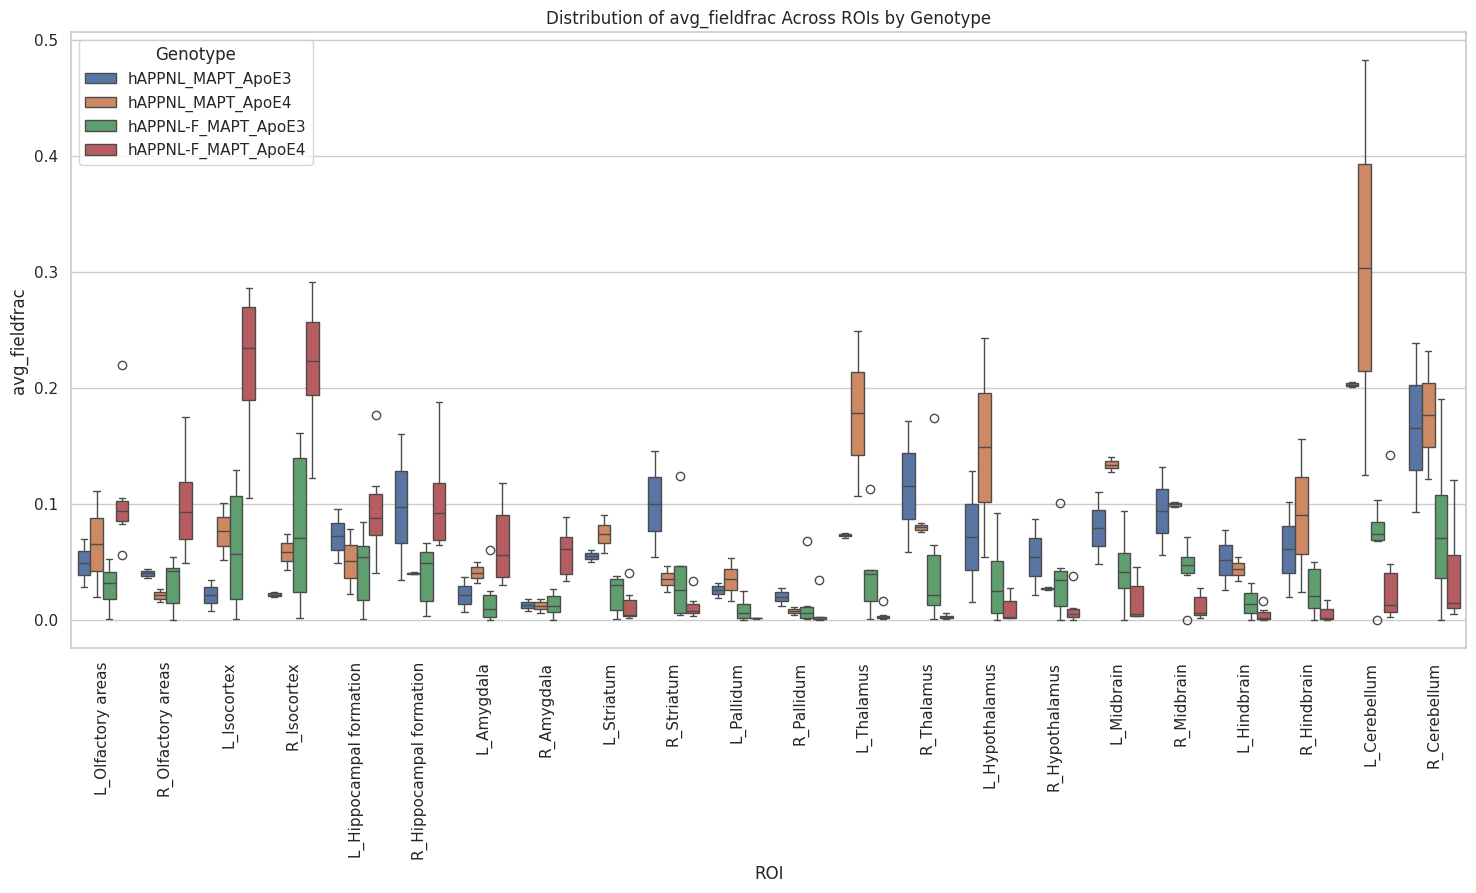

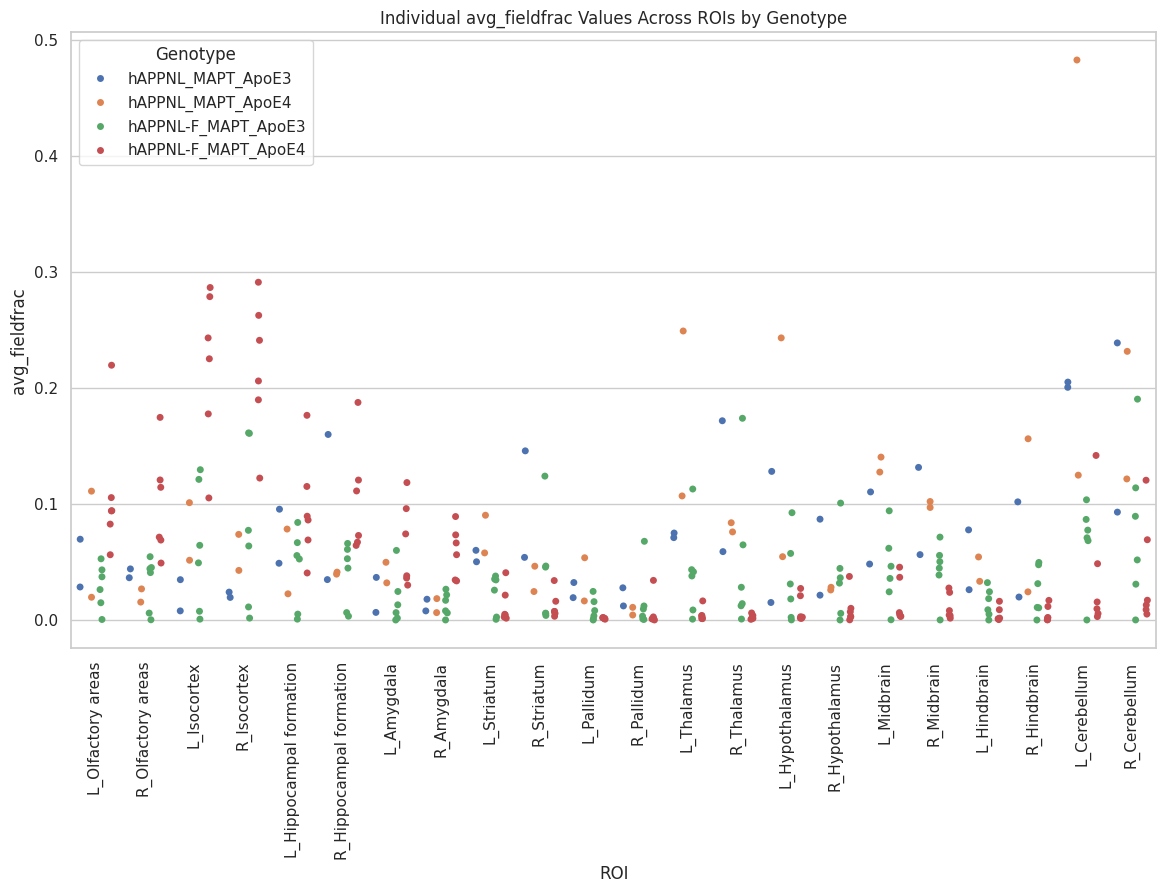

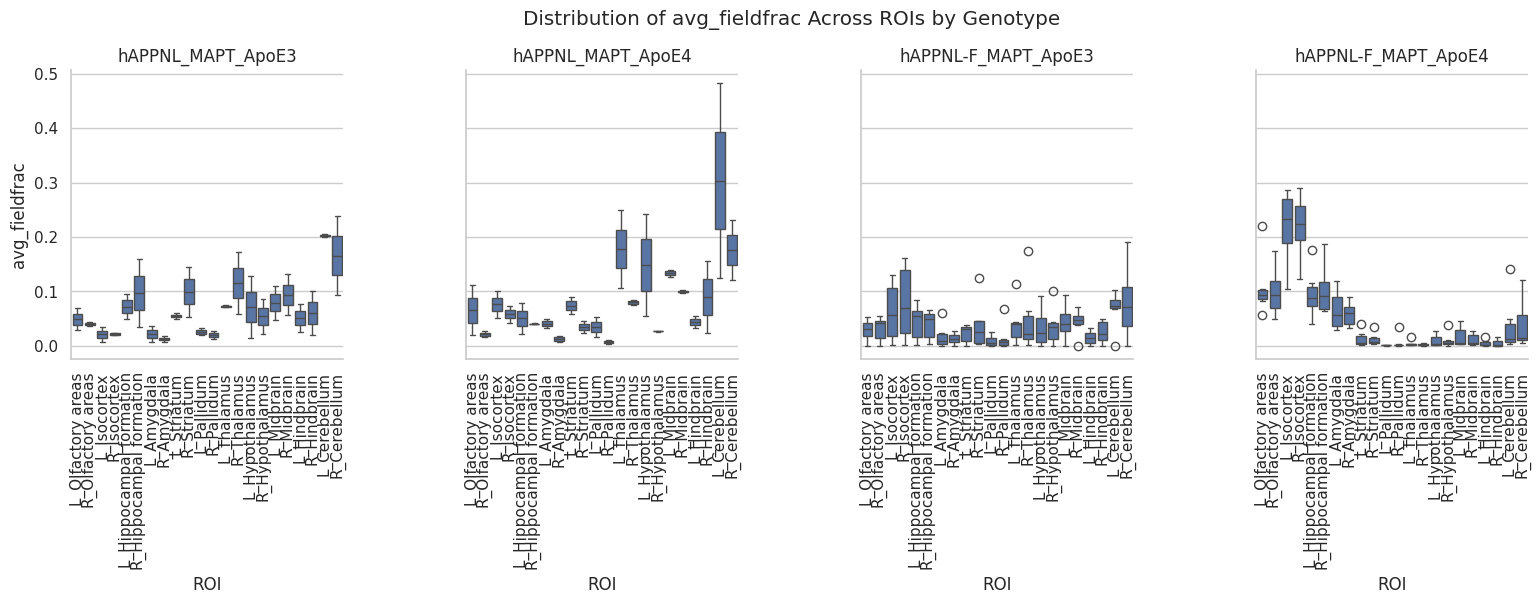

In [212]:
plot_dataframe(merged_data['roi22'])

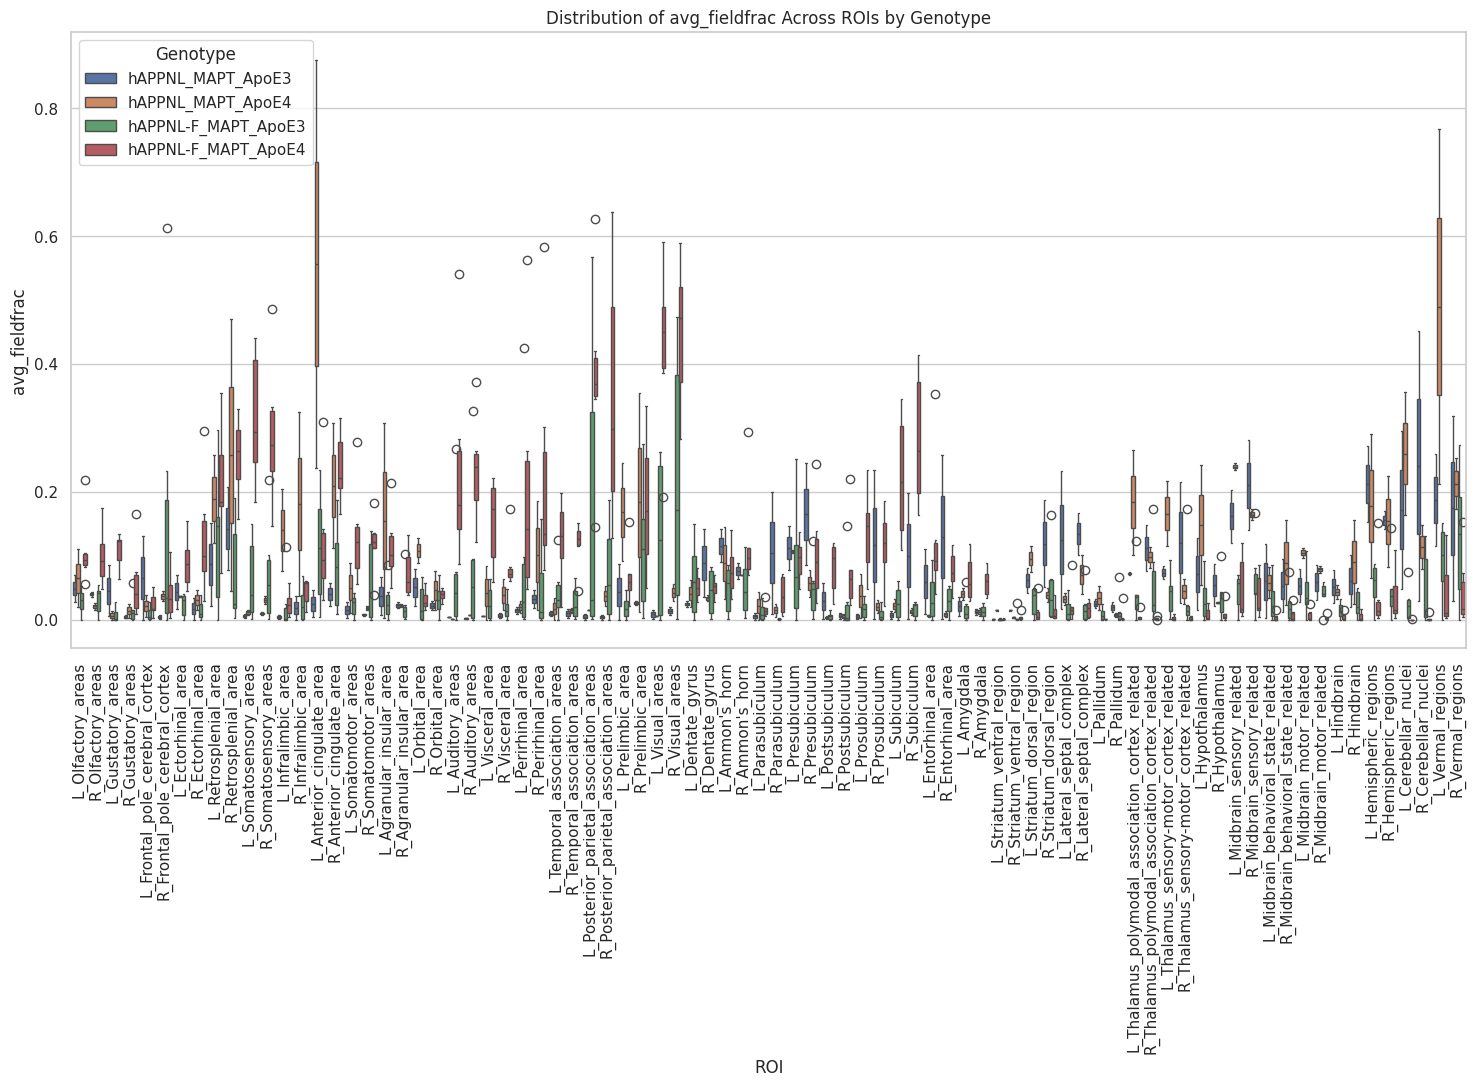

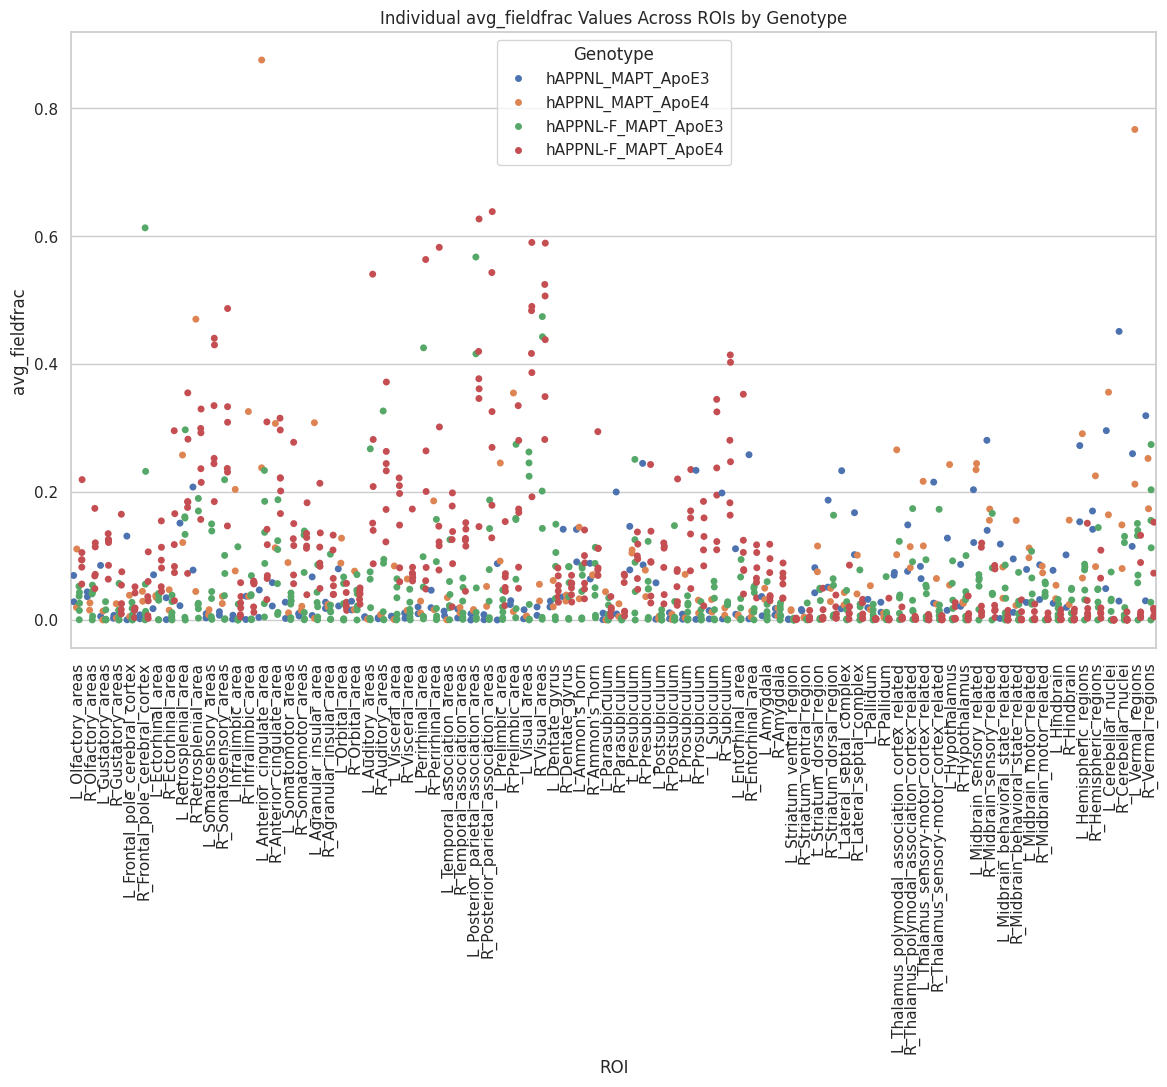

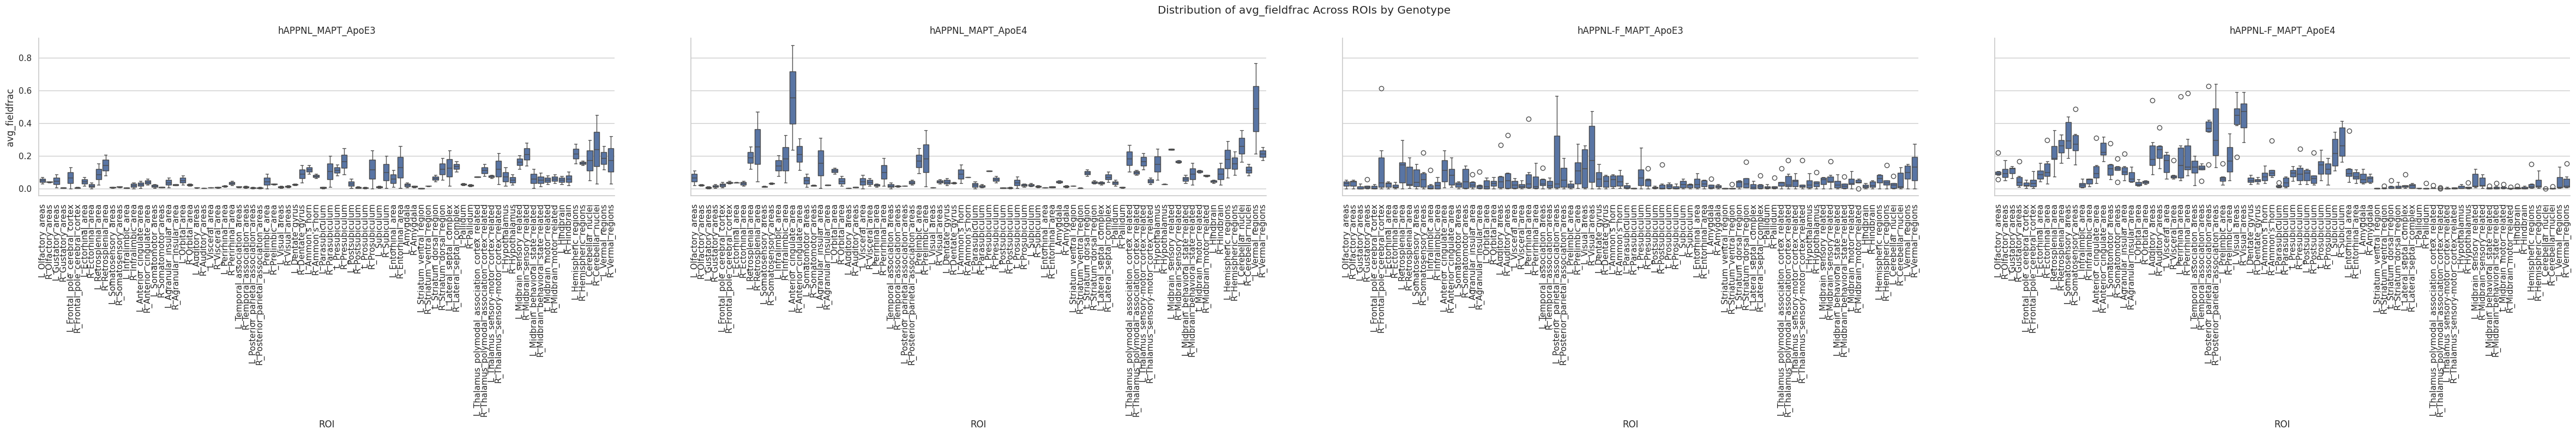

In [213]:
plot_dataframe(merged_data['roi82'],facet_aspect=3)